In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from scipy import optimize

In [15]:
fpath = Path("DATA/231128 PCR plate data.xlsx")
df = pd.read_excel(fpath, sheet_name="Bewerkt")

subdf = df[df["384-barcode"] == 3109845]
subdf.describe()

,384-barcode,Order,type,FAM,distance,RFUmin-f,RFUmax-M,Jump
count,384.0,384.0,384.0,384.000000,384.0,3.840000e+02,3.840000e+02,3.840000e+02
mean,3109845.0,71.0,31.0,5051.818513,0.0,4.897427e+03,4.808839e+03,8.858811e+01
std,0.0,0.0,0.0,1331.599379,0.0,3.005248e-11,2.914180e-11,6.830109e-13
min,3109845.0,71.0,31.0,3587.829584,0.0,4.897427e+03,4.808839e+03,8.858811e+01
25%,3109845.0,71.0,31.0,3832.057987,0.0,4.897427e+03,4.808839e+03,8.858811e+01
50%,3109845.0,71.0,31.0,4224.253649,0.0,4.897427e+03,4.808839e+03,8.858811e+01
75%,3109845.0,71.0,31.0,6418.995970,0.0,4.897427e+03,4.808839e+03,8.858811e+01
max,3109845.0,71.0,31.0,8282.751320,0.0,4.897427e+03,4.808839e+03,8.858811e+01


<Figure size 640x480 with 0 Axes>

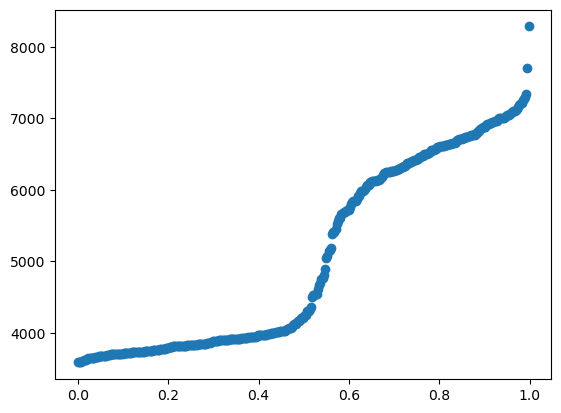

In [20]:
def plot_ecdf(sr: pd.Series):
    plt.figure()

    n = len(sr)
    plt.figure()
    plt.scatter(np.arange(n)/n, sr)
    return

plot_ecdf(subdf.sort_values("FAM").FAM)

C:\Users\lvdtweel.HATCHTECHNL\AppData\Local\Temp\ipykernel_19088\409936226.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

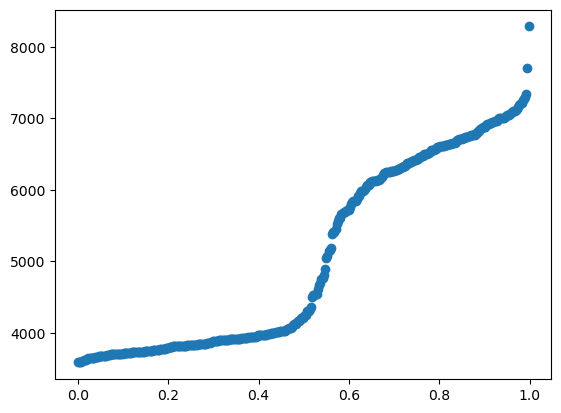

<Figure size 640x480 with 0 Axes>

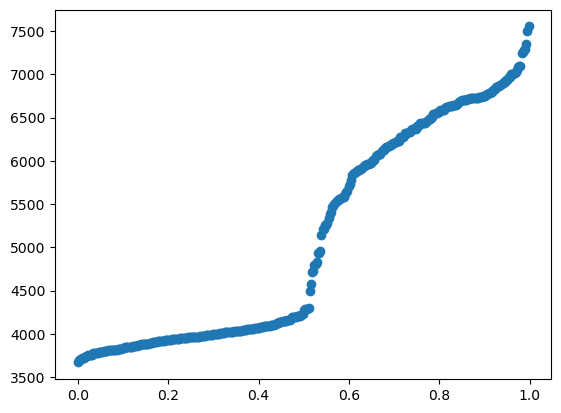

<Figure size 640x480 with 0 Axes>

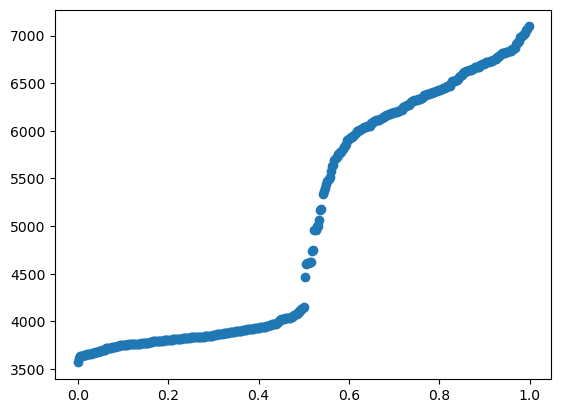

<Figure size 640x480 with 0 Axes>

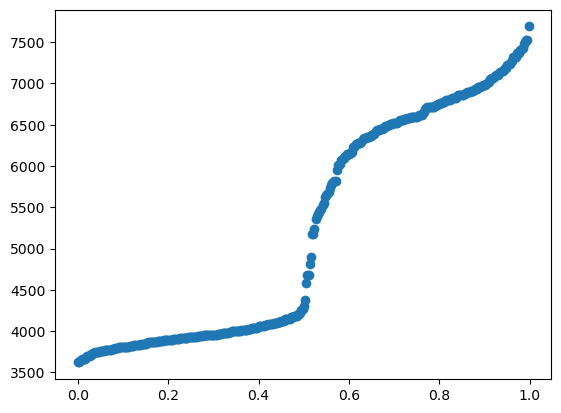

<Figure size 640x480 with 0 Axes>

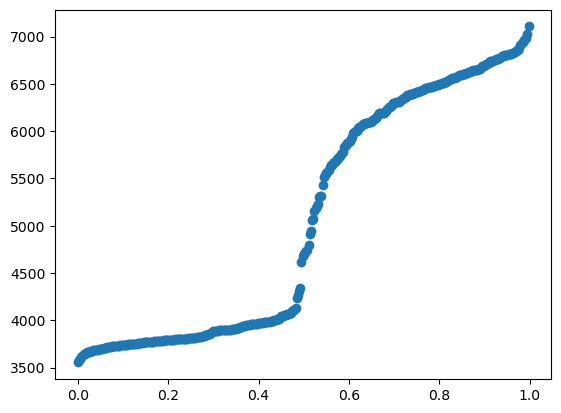

<Figure size 640x480 with 0 Axes>

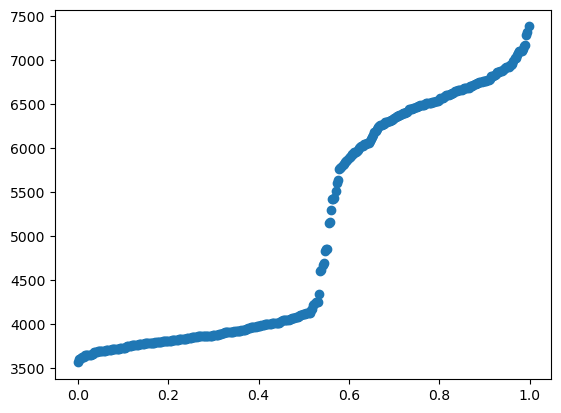

<Figure size 640x480 with 0 Axes>

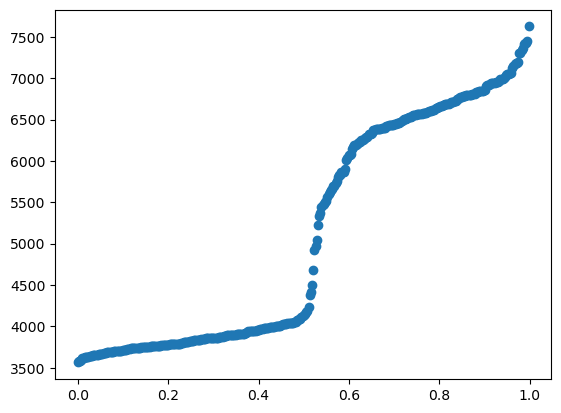

<Figure size 640x480 with 0 Axes>

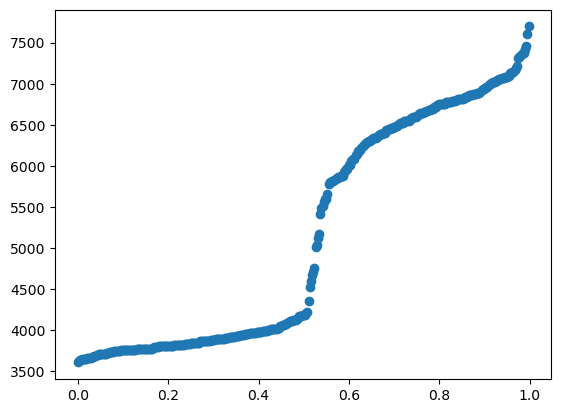

<Figure size 640x480 with 0 Axes>

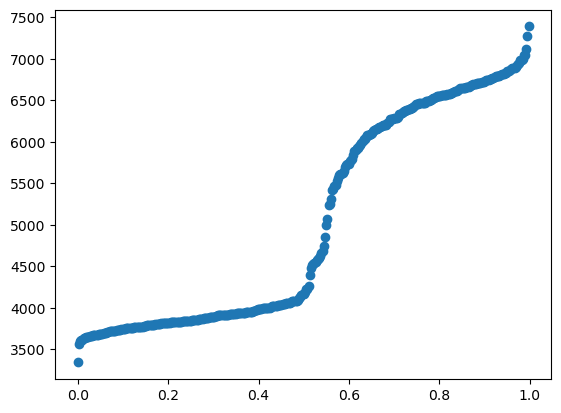

<Figure size 640x480 with 0 Axes>

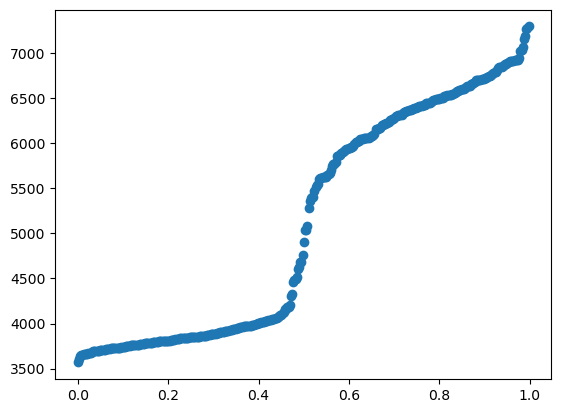

<Figure size 640x480 with 0 Axes>

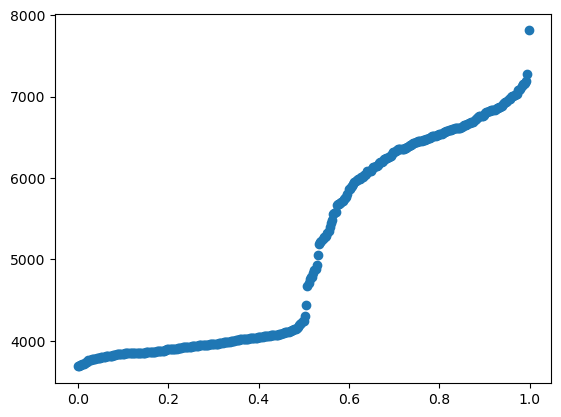

<Figure size 640x480 with 0 Axes>

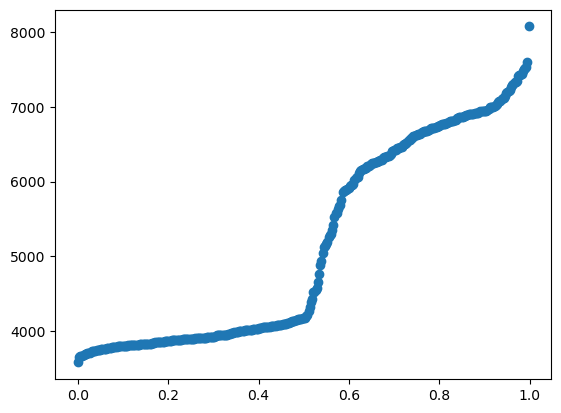

<Figure size 640x480 with 0 Axes>

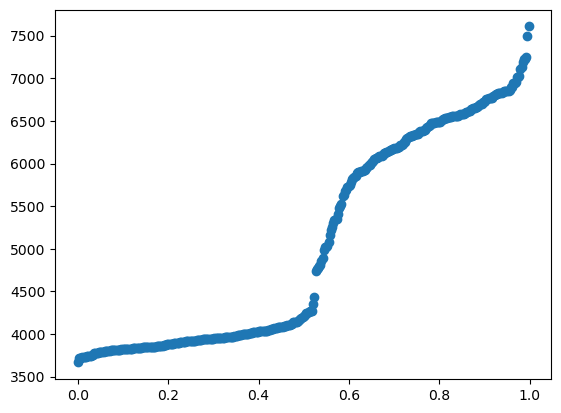

<Figure size 640x480 with 0 Axes>

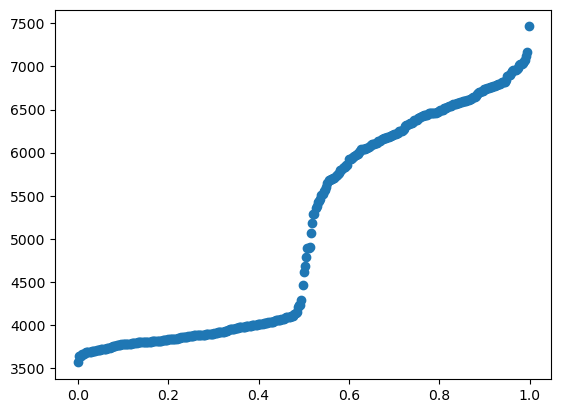

<Figure size 640x480 with 0 Axes>

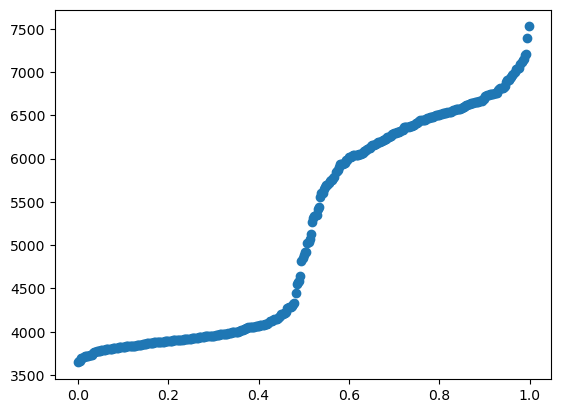

<Figure size 640x480 with 0 Axes>

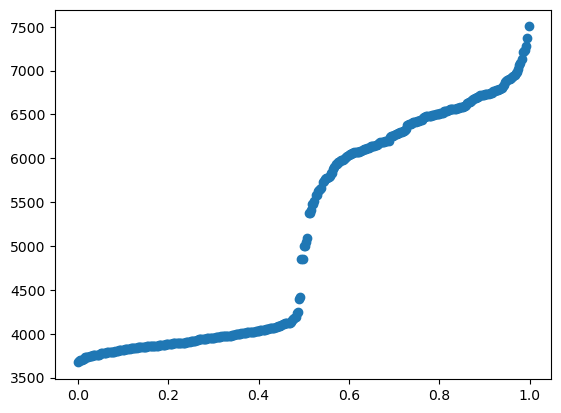

<Figure size 640x480 with 0 Axes>

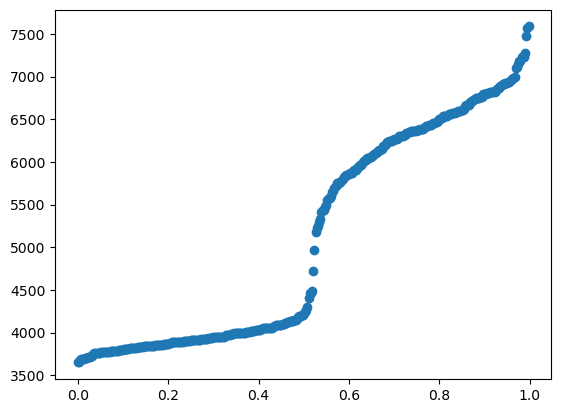

<Figure size 640x480 with 0 Axes>

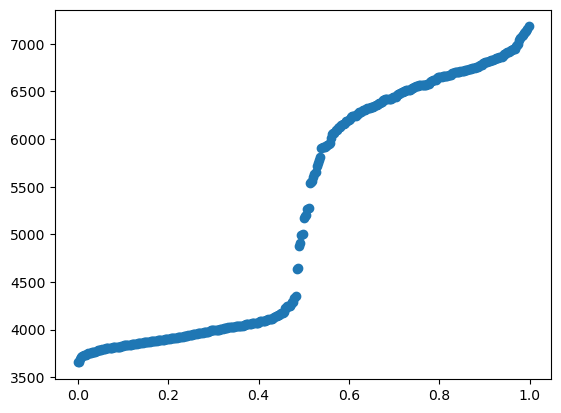

<Figure size 640x480 with 0 Axes>

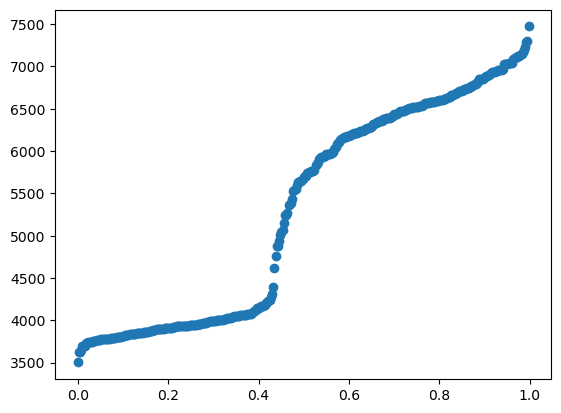

<Figure size 640x480 with 0 Axes>

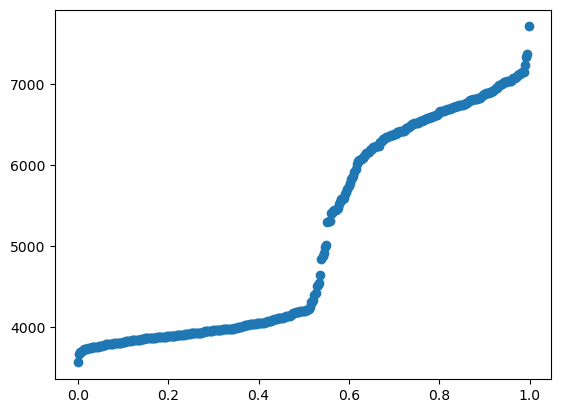

In [38]:
for _, _df in list(df.groupby("384-barcode"))[:20]:
    plot_ecdf(_df.sort_values("FAM").FAM)

In [185]:
def frac_index(sr):
    return np.arange(len(sr)) / len(sr)


def sigmoid(x, k, xc, L):
    # L = y.max()
    # x = frac_index(sr)
    return L / (1 + np.exp(-k * (x - xc)))


def add_bias(X):
    return np.vstack((np.ones(len(X)), X)).transpose()


def linear_regr(X, y):
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y
    return beta


def linear_rec(X, coef, add_bias=True):
    X = np.vstack((np.ones_like(X), X)) if add_bias else X
    return X.transpose() @ coef


def linear_fit(X, y):
    X = np.vstack((np.ones_like(X), X)).transpose()
    y = np.atleast_2d(y).transpose()
    
    coef = linear_regr(X, y)
    return X @ coef

def detrend(sr, start=0.2, end=0.4):
    x = frac_index(sr)
    mask = (x >= start) & (x <= end)

    X = np.vstack((np.ones_like(x), x)).transpose()
    y = sr.to_numpy()[:, np.newaxis]

    coef = linear_regr(X[mask], y[mask])
    ypred = X @ coef
    return sr - ypred.squeeze()


<Figure size 640x480 with 0 Axes>

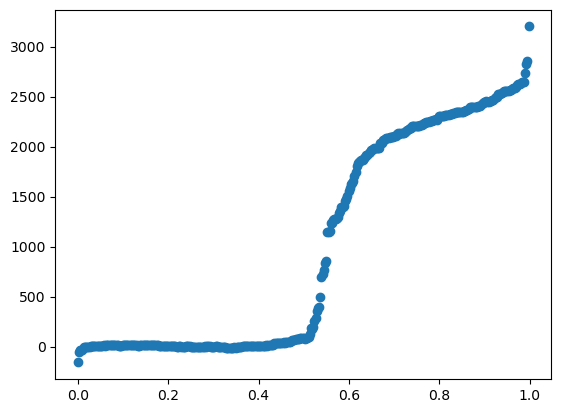

In [71]:
plot_ecdf(detrend(_df.sort_values("FAM").FAM))

In [155]:
y = subdf.sort_values("FAM").FAM.to_numpy()
x = frac_index(y)
x_mask = (x > 0.33) & (x <= 0.66)

yt = detrend(subdf.sort_values("FAM").FAM).to_numpy()
yts = yt/yt.max()
y_mask = (yts > 0.2) & (yts <= 0.8)

coef, jac = optimize.curve_fit(
    sigmoid,
    x[y_mask],
    yts[y_mask],
    maxfev=2000
)

<Figure size 640x480 with 0 Axes>

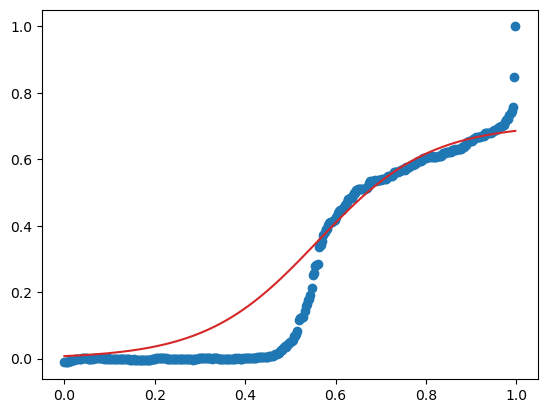

In [156]:
plot_ecdf(yts)
plt.plot(x, sigmoid(x, *coef), color="tab:red")

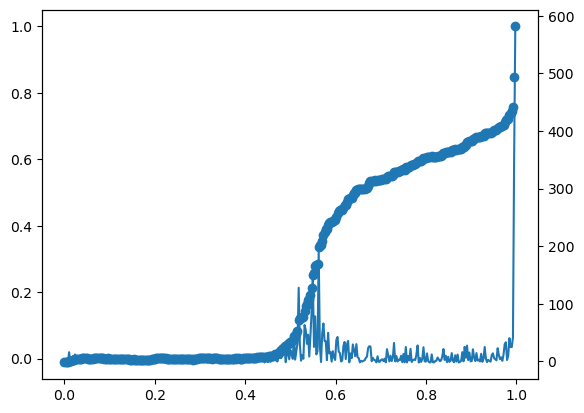

In [121]:
plt.figure()

plt.scatter(x, yt/yt.max())
plt.gca().twinx().plot(x[1:], np.diff(yt))

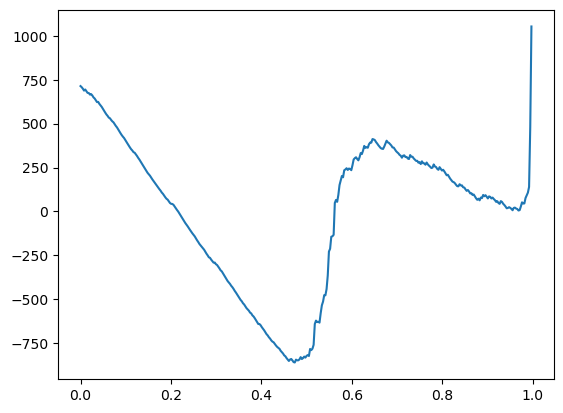

In [159]:
plt.figure()

plt.plot(x, detrend(subdf.sort_values("FAM").FAM, start=0, end=1))

In [169]:
from spreproc.smooth import SavgolFilter

sg = SavgolFilter(31, 3)

In [186]:
for _, _df in list(df.groupby("384-barcode"))[:20]:
    # plot_ecdf(_df.sort_values("FAM").FAM)

    plt.figure()

    y = _df.sort_values("FAM").FAM
    x , y = frac_index(y)[:, np.newaxis], y.to_numpy()
    xb = add_bias(x)

    coef = linear_regr(xb, y)
    # x = detrend(_df.sort_values("FAM").FAM, start=0, end=1).to_numpy()[np.newaxis, :]

    yfit = xb @ coef
    yt = y - yfit
    yt = sg.transform(yt[np.newaxis, :]).squeeze()

    tangent = yfit - yt.min()

    plt.plot(x, y)
    plt.plot(x, yfit)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 384 and the array at index 1 has size 1

<Figure size 640x480 with 0 Axes>